# Practice variety of regressions on 1 df

In [1]:
import geopandas
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn.ensemble
import sklearn.inspection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.utils

import laplan
import utils

cat = intake.open_catalog("../catalogs/*.yml")

In [43]:
tracts = cat.census_tracts.read()

In [89]:
joined = geopandas.read_parquet("../data/toc_df_for_regression.parquet")

## Linear regression
Do a linear regression with just 1 variable, plot to see how line is fitted.

Make map of actual vs predicted.

In [15]:
linear_model = sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False)

In [16]:
linear_variables = [
    "pct_pop_renter",
]
target = "TOC"

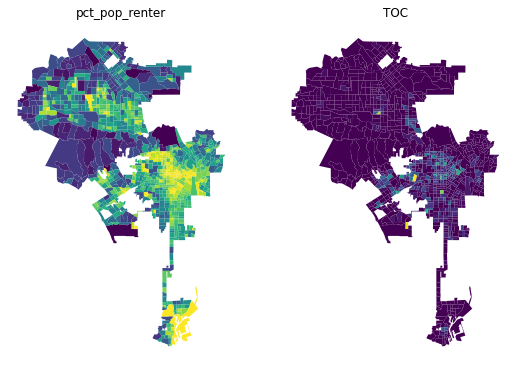

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(9,9))
for i, var in enumerate(linear_variables + ["TOC"]):
    ax = axes.ravel()[i]
    joined.reset_index().plot(ax=ax, column=var)
    ax.axis("off")
    ax.set_title(var)

In [28]:
fit_me = (joined.dropna()
          .assign(
            TOC = joined.TOC.astype(float)
        )[joined.pct_eligible_zoning > 0]
    [linear_variables + [target, "geometry"]]
)

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:828: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [30]:
linear_model.fit(fit_me[linear_variables], fit_me["TOC"])

LinearRegression()

In [31]:
print(linear_model.coef_)
print(linear_model.intercept_)

[4.49226834]
-0.9817701503541141


In [32]:
linear_model_yhat = linear_model.predict(fit_me[linear_variables])

In [49]:
yhat = pandas.DataFrame(linear_model_yhat).rename(columns = {0: "yhat"})
with_yhat = pandas.merge(
                fit_me.reset_index(), 
                yhat, 
                left_index=True, 
                right_index=True)

with_yhat.head()

,GEOID,pct_pop_renter,TOC,geometry,yhat
0,06037101110,0.521214,0.0,"MULTIPOLYGON (((6471651.068 1918306.964, 64719...",1.359661
1,06037101122,0.178417,0.0,"MULTIPOLYGON (((6477840.844 1917081.399, 64778...",-0.180274
2,06037101210,0.876399,0.0,"MULTIPOLYGON (((6475267.737 1915630.020, 64752...",2.955249
3,06037101220,0.603374,0.0,"MULTIPOLYGON (((6477611.571 1915577.225, 64775...",1.728749
4,06037101300,0.083059,0.0,"MULTIPOLYGON (((6481507.143 1914335.333, 64815...",-0.608648


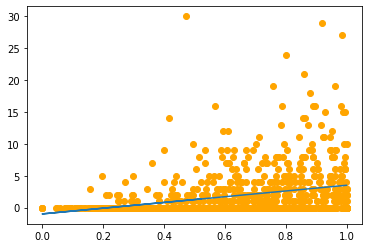

In [50]:
plt.scatter(with_yhat.pct_pop_renter, with_yhat.TOC, color = "orange")
plt.plot(with_yhat.pct_pop_renter, with_yhat.yhat)

In [55]:
map_me = pandas.merge(tracts, with_yhat.drop(columns = "geometry"), 
                       on = "GEOID", how = "left", validate = "1:1")

map_me = map_me.assign(
    yhat = map_me.yhat.fillna(0)
)

In [59]:
# Plot maps of actual TOC vs predicted TOC
def make_map(predictions):
    cmap="plasma"
    fig, axes = plt.subplots(1,2, figsize=(9, 9))
    axes[0].axis("off")
    axes[0].set_title("Actual TOC")
    
    map_me.plot(ax=axes[0], column = "TOC", cmap = cmap)
    
    axes[1].axis("off")
    axes[1].set_title("Predicted TOC")
     
    map_me.plot(ax=axes[1], column="yhat", cmap=cmap)
    
    plt.close(fig)
    return fig

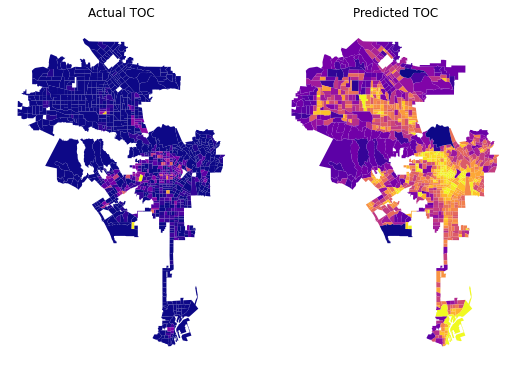

In [60]:
make_map(with_yhat)

## Logistic Regression

Do logistic regression trying to predict `toc_AIN`, which is 0/1.

In [63]:
logistic_model = sklearn.linear_model.LogisticRegression(fit_intercept=True)

In [83]:
logistic_variables = [
    "pct_eligible_zoning"
]
target = "toc_AIN"

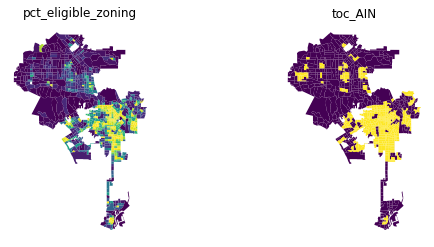

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
for i, var in enumerate(logistic_variables + ["toc_AIN"]):
    # Can also designate which specific grid if we wanted to do a 2x3 grid
    #ax1 = plt.subplot2grid((3,2),(0, 0))
    ax = axes.ravel()[i]
    joined.reset_index().plot(ax=ax, column=var)
    ax.axis("off")
    ax.set_title(var)

In [91]:
logistic_model.fit(joined[logistic_variables], joined["toc_AIN"])

LogisticRegression()

In [92]:
logistic_model_yhat = logistic_model.predict(joined[logistic_variables])

In [93]:
yhat = pandas.DataFrame(logistic_model_yhat).rename(columns = {0: "yhat"})
with_yhat = pandas.merge(
                joined.reset_index(), 
                yhat, 
                left_index=True, 
                right_index=True)

with_yhat.head()

,GEOID,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,pop_whitenonhisp,...,Tier_1,Tier_2,Tier_3,Tier_4,total_AIN,pct_toc_AIN,toc_AIN,geometry,pct_eligible_zoning,yhat
0,06037101110,46,1927,0.023871,0,0.000000,2199,4219,0.521214,2516,...,0.0,0.0,0.0,0.0,1274,0.0,False,"MULTIPOLYGON (((6471651.068 1918306.964, 64719...",0.148352,False
1,06037101122,11,1907,0.005768,8,0.004195,577,3234,0.178417,2755,...,0.0,0.0,0.0,0.0,1475,0.0,False,"MULTIPOLYGON (((6477840.844 1917081.399, 64778...",0.004068,False
2,06037101210,171,2770,0.061733,114,0.041155,5247,5987,0.876399,2991,...,0.0,0.0,0.0,0.0,629,0.0,False,"MULTIPOLYGON (((6475267.737 1915630.020, 64752...",0.941176,True
3,06037101220,54,1513,0.035691,54,0.035691,2110,3497,0.603374,1694,...,0.0,0.0,0.0,0.0,814,0.0,False,"MULTIPOLYGON (((6477611.571 1915577.225, 64775...",0.470516,True
4,06037101300,86,2041,0.042136,10,0.004900,353,4250,0.083059,3503,...,0.0,0.0,0.0,0.0,2022,0.0,False,"MULTIPOLYGON (((6481507.143 1914335.333, 64815...",0.020277,False


In [94]:
map_me = pandas.merge(tracts, with_yhat.drop(columns = "geometry"), 
                       on = "GEOID", how = "left", validate = "1:1")

map_me = map_me.assign(
    yhat = map_me.yhat.fillna(0)
)

In [95]:
# Plot maps of actual TOC vs predicted TOC
def make_map(predictions):
    cmap="plasma"
    fig, axes = plt.subplots(1,2, figsize=(9, 9))
    axes[0].axis("off")
    axes[0].set_title("Actual toc_AIN")
    
    map_me.plot(ax=axes[0], column = "toc_AIN", cmap = cmap)
    
    axes[1].axis("off")
    axes[1].set_title("Predicted toc_AIN")
     
    map_me.plot(ax=axes[1], column="yhat", cmap=cmap)
    
    plt.close(fig)
    return fig

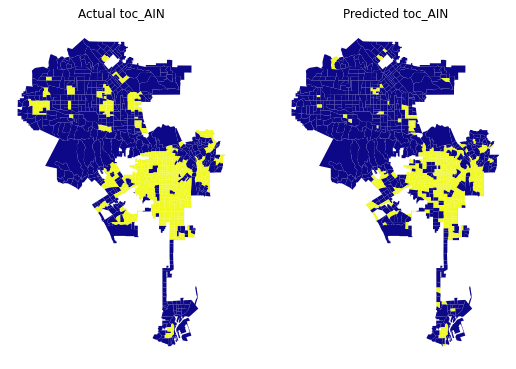

In [98]:
make_map(with_yhat)

## Random Forest

In [106]:
variables = [
    "medhhincome",
    "pct_pop_renter",
    "pct_zero_veh_workers",
    "density",
    "pct_whitenonhisp",
    "pct_eligible_zoning", 
    "Tier_1",
    "Tier_2",
    "Tier_3",
    "Tier_4",
]
target = "TOC"

In [100]:
to_fit = joined[
    (joined.Tier_1 > 0) |
    (joined.Tier_2 > 0) |
    (joined.Tier_3 > 0) |
    (joined.Tier_4 > 0)
]

In [101]:
# Set a max depth to avoid over-fitting
random_forest_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.ensemble.RandomForestRegressor(max_depth=10)),
])

In [116]:
# VERY SMALL CHANGES (original tracts already has index set to GEOID)
def plot_model(predictions):
    vmin=0
    vmax=0.15
    cmap="plasma"
    fig, axes = plt.subplots(1,2, figsize=(16, 16))
    axes[0].axis("off")
    axes[0].set_title("Actual TOC/parcel")
    (tracts.set_index("GEOID")
     .assign(
         TOC=to_fit.TOC,
         # MINOR CHANGE HERE
         norm_TOC=to_fit.TOC.divide(to_fit.total_AIN),
     ).fillna({"TOC": 0, "norm_TOC": 0})
     .plot(ax=axes[0],column="norm_TOC", vmax=vmax, vmin=vmin, cmap=cmap)
    )
    axes[1].axis("off")
    axes[1].set_title("Predicted TOC/parcel")
    (tracts.set_index("GEOID")
     .assign(
         predictions=pandas.Series(predictions, index=to_fit.index),
         # MINOR CHANGE HERE
         norm_pred=pandas.Series(predictions, index=to_fit.index).divide(to_fit.total_AIN),
     )
     .fillna({"predictions": 0, "norm_pred": 0})
     .plot(ax=axes[1],column="norm_pred", cmap=cmap, vmin=vmin, vmax=vmax)
    )
    plt.close(fig)
    return fig

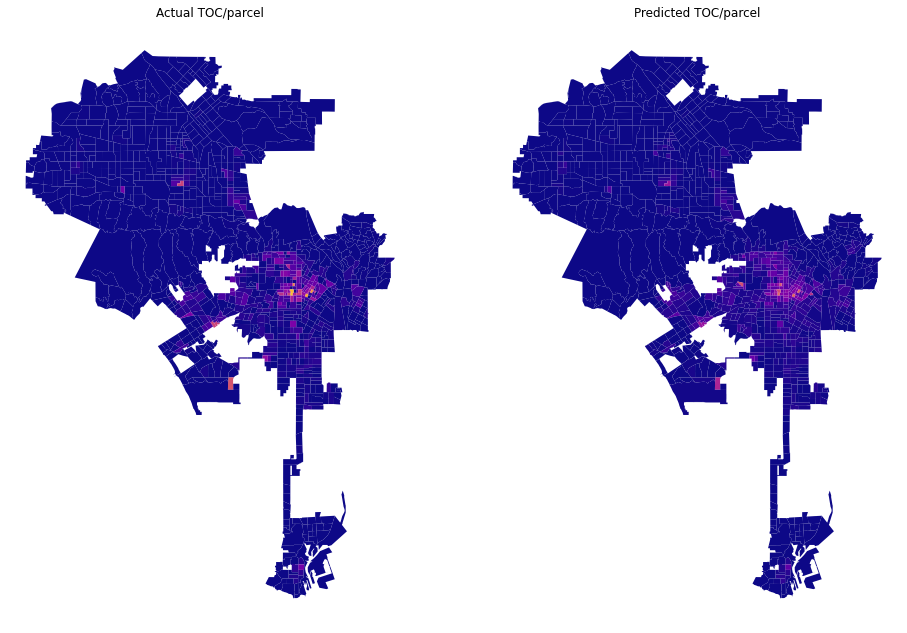

In [117]:
np.random.seed(1)

random_forest_model.fit(to_fit[variables], to_fit[target])
plot_model(random_forest_model.predict(to_fit[variables]))

## Poisson Regression